# Overview of Bayesian linear regression

Bayesian linear regression (Bayes-LR) is another type of linear regression applied to Bayes’ theorem. The main difference between `Bayesian` and `Frequentist` linear regression:
- `Bayesian` infers the distribution of parameters.
- `Frequentist` derives fixed parameters.

Let say:
- $y$: dependent variable
- $x$: independent variable (input data)
- $\beta_0, \beta_1$: parameters

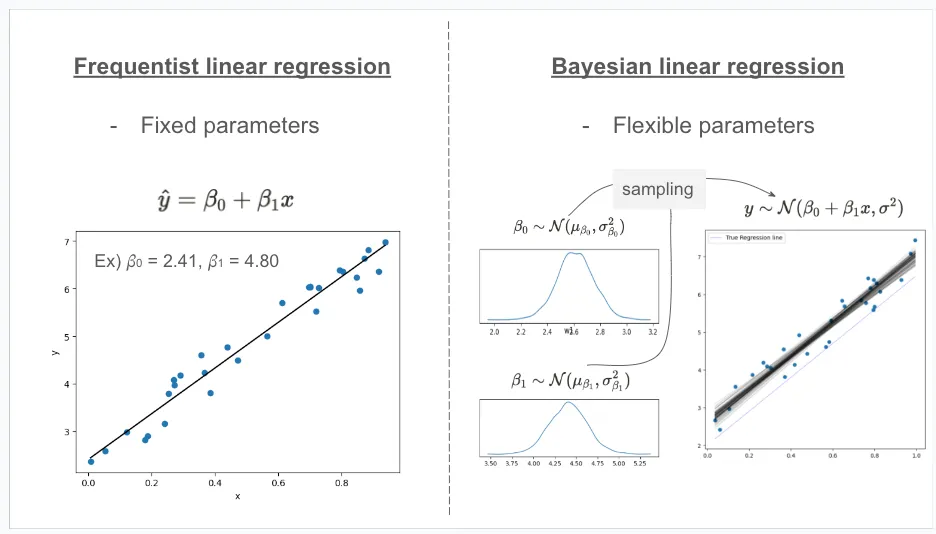

Bayes-LR defines arbitrary probability distributions for each parameter (the example uses a Gaussian distribution for all parameters and predicted values). Bayes-LR considers various plausible assumptions about how input data is generated. 

The pros:
- can also infer the predictions by averaging over lots of sampled parameters.
- can know the confidence of predictions.
- can focus on uncertain space and add data based on it.
- can make more robust estimations, especially with the smaller dataset.

The cons:
- need a lot of computation.
- Unless carefully selecting the probability distribution (prior and likelihood), the conclusion may be wrong.

# Mathematical background of Bayes-LR

Let say:
- $y\in\mathbb{R}^n$: dependent variable
- $\hat{y}\in\mathbb{R}^n$: predicted dependent variable
- $X\in\mathbb{R}^{n\times p}$: independent variable (input data)
- $\beta\in\mathbb{R}^p$: parameters
- $\epsilon\in\mathbb{R}^n$: residuals

Least squared error: $\mathcal{L}(y,\hat{y})=||\epsilon||^2_2=||y-\hat{y}||^2_2$

Bayes's theorem: 
$$\text{posterior} = \frac{\text{likelihood}.\text{prior}}{\text{evidence}}\sim\text{likelihood}.\text{prior}$$

When apply Bayes theorem to LR, the Bayes formula:
$$p(\beta|\epsilon)\sim p(\epsilon|\beta).p(\beta)$$

- `likelihood` refers to the probability density values of the residuals given parameters.
- `prior` refers to the probability density values of the parameters
- `posterior` refers to the probability density values of parameters given the residuals. 

Before calculating this formula, we need to define the probability distribution that each term follows. Usually, it's the Gaussian distribution (Gaussian Processes - GPs) for guarantee to convergence.

For `prior` distribution, we assume the Gaussian distribution as a weakly informative prior:
$$\beta \sim \mathcal{N}(0,S)$$

For `likelihood`, we want to minimize the residual, so:
$$\epsilon|\beta \sim \mathcal{N}(0,\sigma^2I)$$

$
\begin{array}{ll}
\text{posterior}&\sim \text{likelihood}.\text{prior} \\
                &= -\frac{1}{2}(\beta-\mu)^T\sum^{-1}(\beta-\mu)+ \text{const}
\end{array}
$

where: $\sum^{-1} = \frac{1}{\sigma^2}X^TX+S^{-1}$, $\mu=\frac{1}{\sigma^2}\sum y^TX$


The `derived posterior` distribution:
$$\beta|\epsilon \sim \mathcal{N}(\mu,\sum)$$

Based on this derivation, `Gaussian prior` leads to a `Gaussian posterior`. When we get more data, we use the `posterior` as `prior` and update the distribution. When we want to inference based on new data, we just sample the parameters and substitute them in the linear regression equation.

Since we assume a Gaussian distribution as a `prior`, we can calculate the `posterior` distribution. However, we generally cannot calculate the `posterior` distribution in a closed-solution. In such a case, we need to use the MCMC(Markov chain mote Carlo) method to sample for one answer solution.

# Implementation

In [3]:
import pymc as pm
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pytensor.tensor as at

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [10]:
n_samples = 30

w0 = 2.0
w1 = 4.5

x = np.sort(np.random.rand(n_samples))
y = w1 * x + w0 + np.random.rand(n_samples)

In [11]:
model = pm.Model()

with model:
    w0_hat = pm.Normal("w0", mu=0, sigma=10)
    w1_hat = pm.Normal("w1", mu=0, sigma=10)
    sigma = pm.HalfNormal("sigma", sigma=1)

    mu = w0_hat + w1_hat * x  

    y_hat = pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y)

In [12]:
with model:
    sample = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w0, w1, sigma]


c:\Users\dangc\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 82 seconds.


array([[<Axes: title={'center': 'w0'}>, <Axes: title={'center': 'w0'}>],
       [<Axes: title={'center': 'w1'}>, <Axes: title={'center': 'w1'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

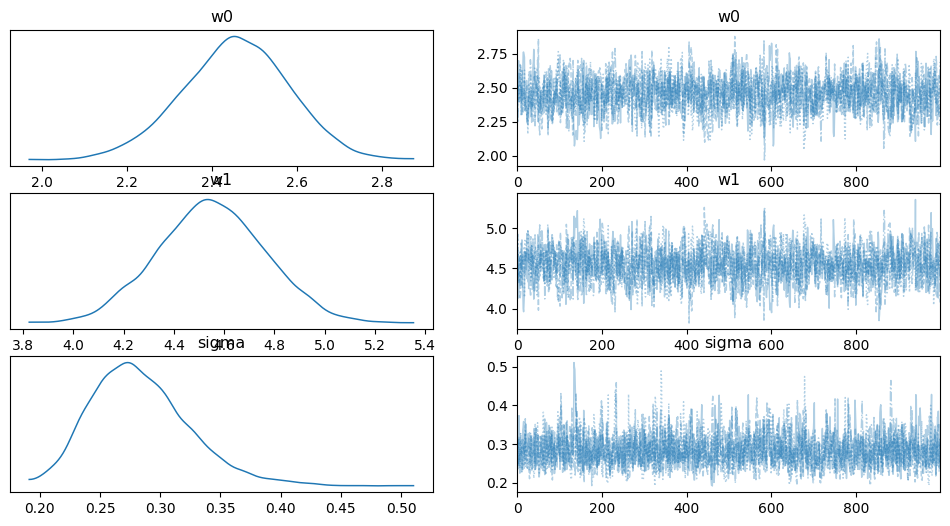

In [13]:
az.plot_trace(sample, combined=True)

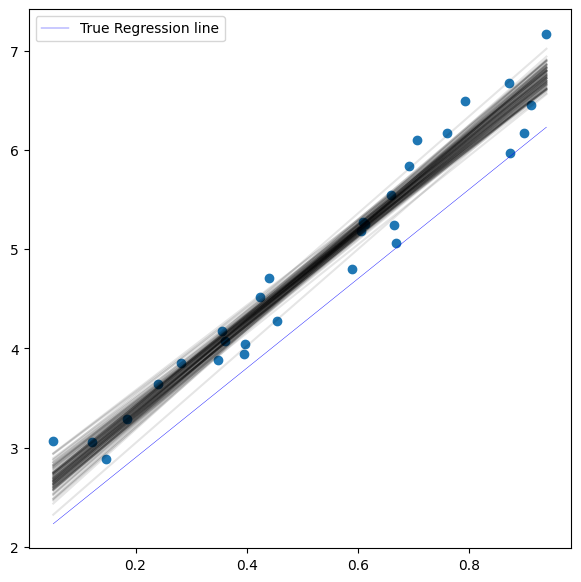

In [14]:
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(x, y)

# extract intercept(w0) draws from PyMC
w0_ = sample.posterior.w0.to_numpy()[0]
w1_ = sample.posterior.w1.to_numpy()[0]

sample_indexes = np.random.randint(len(w0_), size=100)

for i in sample_indexes:
    y_line = w0_[i] + w1_[i] * x
    ax.plot(x, y_line, c='black', alpha=0.1)

true_y = w0 + w1 * x
ax.plot(x, true_y, label="True Regression line", lw=.3, c='blue')
ax.legend(loc=0)
plt.show()

## Student performance dataset

In [ ]:
df = pd.read_csv('Student_performance.csv')
df.head(3)

In [ ]:
pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(30, 30))

The performance index follows a Gaussian-like distribution, so choosing a Bayesian linear regression model may not be a terrible choice. Then, we assume the parameter and dependent variable follow the Gaussian distribution.

Let say:
- $\beta\in\mathbb{R}^5$
- $X\in\mathbb{R}^{9873\times 5}$
- $y\in\mathbb{R}^9873$
- $X_i\in\mathbb{R}^5$
- $\beta _j\in\mathcal{N}(0,S_j)$
- $y_i\in\mathcal{N}(\beta^TX,\sigma^2)$

Note that we assume the residuals follows the Gaussian distribution with mean 0 in the previous section. In this case, we assume the dependent variable follows the Gaussian distribution with mean the predicted value from linear regression for convenience. It seems different but is equivalent (you can check when you formulate both settings).

In [ ]:
le = LabelEncoder()

df['Extracurricular Activities'] = le.fit_transform(df['Extracurricular Activities'])

In [ ]:
df = df[~df.duplicated()]
df = df.dropna().astype(float)

columns = df.columns.values[:-1] 

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X = X.astype(float)
y = y.astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print('train and test size')
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
test_score_bayesian = pm.Model(coords={"predictors": columns})

with test_score_bayesian:
    # posterior variance
    sigma = pm.HalfNormal("sigma", 25)

    # beta
    beta = pm.Normal("beta", 0, 10, dims="predictors")
    beta0 = pm.Normal("beta0", 0, 10)

    mu = beta0 + at.dot(X_train, beta)
    
    y_hat = pm.Normal("y_hat", mu=mu, sigma=sigma, observed=y_train)

In [ ]:
pm.model_to_graphviz(test_score_bayesian)

In [ ]:
with test_score_bayesian:
    sample = pm.sample()

In [ ]:
az.plot_trace(sample, var_names=["beta0", "sigma"])

In [ ]:
az.plot_forest(sample, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True)

The coefficients obtained from Bayesian linear regression model and frequentist one.

In [ ]:
az.summary(sample)

obtain the almost same result. The reason is that we assume the Gaussian distribution for prior, which is also implicit in the frequentist setting. When you have an additional information about prior, you can freely change the prior distribution and get more plausible result.

Pros of GPs:
- **Uncertainty:** Apart from modeling plain predictions, GPs take it a step further by measuring the uncertainty of predictions.
- **Complexity:** GPs can model complex non-linear problems.

Cons of GPs:
- **Kernel:** GPs add another hyperparameter in the form of the kernel - the covariance function (if use sklearn [2]). Selecting the optimal kernel for modeling the problem can be challenging.

___

Loading dataset

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data.
data = pd.read_csv("stats/response_stats.csv")

# Separate features and target.
X = data[["Likes", "Comments", "Read Time"]]
y = data["Earnings"]
X["Title"] = data["Title"]

# (Optional) I will be working with earnings, earnings cannot be negative,
# therefore I have converted the y-values to logarithmic scale.
y += 1
y = np.log(y)

# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# (Optional) Save titles.
test_titles = X_test["Title"]
X_train = X_train.drop(columns="Title")
X_test = X_test.drop(columns="Title")

# eXtreme Gradient Boosting (XGBoost)

XGBoost is a machine-learning algorithm based on gradient boosting. Gradient boosting builds on the idea of ensembles of decision trees. e.g.

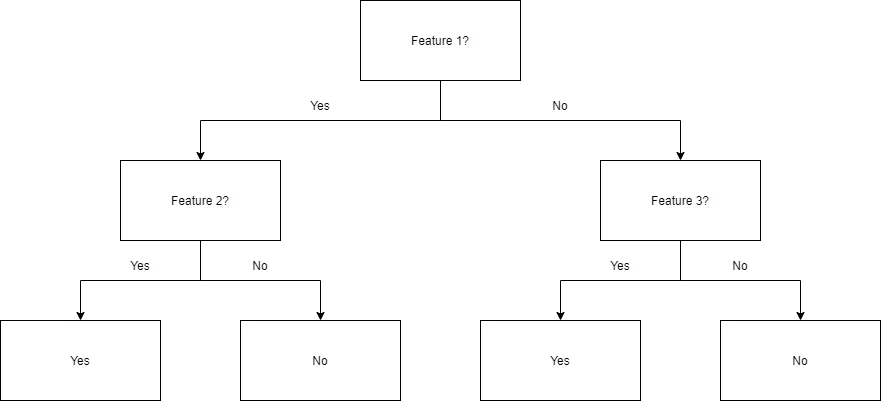

Pros:
- **Complexity:** XGBoost can learn complex non-linear relationships.
- **Performance:** XGBoost generally has good out-of-the-box performance and comes with built-in regularization to prevent overfitting.

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize and train the XGBoost model.
model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)

# Predict on the test set.
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1

# Evaluate the model
mse = mean_squared_error(np.exp(y_test) - 1, y_pred)
r2 = r2_score(np.exp(y_test) - 1, y_pred)  # (Optional) Omit if you don't use logarithmic scaling.

print(f"MSE: {mse:.2f}")
print(f"R2 Score: {r2:.2f}")

# (Optional) Print the title, actual earnings, and predicted earnings.
for title, actual, predicted in zip(test_titles, np.exp(y_test) - 1, y_pred):
    print(f"Title: {title}, Actual Earnings: ${actual:.2f}, Predicted Earnings: ${predicted:.2f}")

# Reference
[1] [Gentle introduction of Bayesian Linear Regression](https://medium.com/intuition/gentle-introduction-of-bayesian-linear-regression-c83da6b0d1f7)

[2] [GPs vs. Linear Regression vs. XGBoost](https://medium.com/internet-of-technology/gps-vs-linear-regression-vs-xgboost-886fac83d5a3)